In [91]:
import pickle
import pandas as pd
import numpy as np
import ast
import torch # needs to be installed when executed in NORTH
import re
from rdkit import Chem # rdkit needs to be installed when executed in NORTH
from rdkit.Chem import Descriptors, rdmolfiles, rdmolops
from torch_geometric.data import Data, DataLoader # torch_geometric also install when in NORTH
import requests

# Download data from NOMAD

In [93]:
base_url = 'https://nomad-lab.eu/prod/v1/api/v1/'

def extract_values(entry):
    try:
        bandgaps.append(entry['results']['properties']['electronic']['band_structure_electronic'][0]['band_gap'][0]['value'])
    except:
        bandgaps.append('None')
    try:
        reduced_formulas.append(entry['results']['material']['chemical_formula_reduced'])
        iupac_formulas.append(entry['results']['material']['chemical_formula_iupac'])
        descriptive_formulas.append(entry['results']['material']['chemical_formula_descriptive'])
    except:
        reduced_formulas.append('None')
        iupac_formulas.append('None')
        descriptive_formulas.append('None')
    try:
        vocs.append(entry['results']['properties']['optoelectronic']['solar_cell']['open_circuit_voltage'])
    except:
        vocs.append('None')
    try:
        jscs.append(entry['results']['properties']['optoelectronic']['solar_cell']['short_circuit_current_density'])
    except:
        jscs.append('None')
    try:
        ffs.append(entry['results']['properties']['optoelectronic']['solar_cell']['fill_factor'])
    except:
        ffs.append('None')
    try:
        pce.append(entry['results']['properties']['optoelectronic']['solar_cell']['efficiency'])
    except:
        pce.append('None')
    try:
        device_stack.append(entry['results']['properties']['optoelectronic']['solar_cell']['device_stack'])
    except:
        device_stack.append('None')
    try:
        htl.append(entry['results']['properties']['optoelectronic']['solar_cell']['hole_transport_layer'])
    except:
        htl.append('None')
    try:
        etl.append(entry['results']['properties']['optoelectronic']['solar_cell']['electron_transport_layer'])
    except:
        etl.append('None')
    try:
        structural_dimensionality.append(entry['results']['material']['structural_type'])
    except:
        structural_dimensionality.append('None')
    try:
        da.append(entry['results']['properties']['optoelectronic']['solar_cell']['device_area'])
    except:
        da.append('None')
    try:
        ill_int.append(entry['results']['properties']['optoelectronic']['solar_cell']['illumination_intensity'])
    except:
        ill_int.append('None')
    return bandgaps, reduced_formulas, iupac_formulas, descriptive_formulas, vocs, jscs, ffs, pce, device_stack, htl, etl, structural_dimensionality, da, ill_int

bandgaps =[]
vocs = []
jscs = []
ffs = []
pce = []
reduced_formulas = []
iupac_formulas = []
descriptive_formulas = []
htl = []
etl = []
device_stack = []
structural_dimensionality = []
da = []
ill_int = []

page_after_value = None

count = 0

while True:
    count = count + 1
    print(f"Progress: {count}/43")
    data = requests.post(f'{base_url}entries/query', json={
        "owner": "visible",
        "aggregations": {},
        "query": {
            "and": [
                {"sections:all": ["nomad.datamodel.results.SolarCell"]},
                ]},
        "required": {
            "results":{
                "material": {
                    "chemical_formula_reduced":"*",
                    "structural_type":"*"},
                "properties": {
                   "optoelectronic":{
                      "band_gap":"*",
                      "solar_cell":{
                          "open_circuit_voltage":"*",
                          "short_circuit_current_density":"*",
                          "fill_factor":"*",
                          "efficiency":"*",
                          }}},},
        },
        "pagination": {"page_size": 1000,
                       "page_after_value": page_after_value}
        }).json()


    if not data['data']:
        break
    if 'next_page_after_value' not in data['pagination'].keys():
    # make sure to grasp the entries of the last page before breaking
        for entry in data['data']:
            if 'results' not in entry.keys():
                continue
            else:
                extract_values(entry)
        break
    page_after_value = data['pagination']['next_page_after_value']

    for entry in data['data']:
        if 'results' not in entry.keys():
            continue
        else:
            extract_values(entry)
            
df = pd.DataFrame({
    'reduced_formulas': reduced_formulas,
    'iupac_formulas': iupac_formulas,
    'descriptive_formulas': descriptive_formulas,
    'bandgap': bandgaps,
    'voc': vocs,
    'jsc': jscs,
    'ff': ffs,
    'pce': pce,
    'device_stack': device_stack,
    'htl': htl,
    'etl': etl,
    'structural_dimensionality': structural_dimensionality,
    'ill_int': ill_int,
    'device_area': da,
    })

df.to_csv('data/df_all_cells_many_properties_NORTH.csv', index=False)

still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going


In [102]:
df.to_csv('data/df_all_cells_many_properties_NORTH.csv', index=False)

# Data preparation

In [189]:
# load data
# Build a dataframe that contains all predictors and only contains fully identified cells for a start
df = pd.read_csv('data/df_all_cells_many_properties_NORTH.csv')
print(f"Raw data length: {len(df)}.")

# eliminate all cells that have non-identified htls or etls. This pickle
# was created in How_many_cells_identified.ipynb
with open('data/df_all_ctls_identified_v2.pkl', 'rb') as f:
    df_id = pickle.load(f)
print(f"Length of CTL identification info: {len(df_id)}.")

# add the both_identified column to df and only keep the fully identified cells
df['both_identified'] = df_id['both_identified']
df_all_identified = df[df['both_identified'] == True]
print(f"After keeping only fully identified CTLs: {len(df_all_identified)}.")

# drop cells without a device stack information (306)
df_all_identified['device_stack'].apply(ast.literal_eval)
df_all_identified = df_all_identified.dropna(subset=['device_stack'])
print(f"After dropping NAs in device stack: {len(df_all_identified)}.")

# drop cells without reduced_formulas
df_all_identified = df_all_identified[df_all_identified['reduced_formulas'] != "None"]
print(f"After dropping None strings in reduced_formulas: {len(df_all_identified)}.")

df_all_identified = df_all_identified.dropna(subset=['reduced_formulas'])
print(f"After dropping NAs in reduced_formulas: {len(df_all_identified)}.")

# eliminate cells that were measured at an illumination intensity other than 1000 W/m^2
df_all_identified['ill_int'] = pd.to_numeric(df_all_identified['ill_int'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['ill_int'] == 1000]
print(f"After dropping cells that were measured at illumination intensity other than 1000 W/m^2: {len(df_all_identified)}.")

# eliminate rows with large device areas
df_all_identified['device_area'] = pd.to_numeric(df_all_identified['device_area'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['device_area'] <= 0.000025]
print(f"After dropping cells with device area greater than 25 mm^2: {len(df_all_identified)}.")


# drop everything that is not further needed
df_all_identified = df_all_identified.drop(columns=['voc', 
                                                    'jsc', 
                                                    'ff', 
                                                    'structural_dimensionality', 
                                                    'both_identified', 
                                                    'device_stack',
                                                    'ill_int',
                                                    'device_area',
                                                   ])

# transform etl and htl to lists
df_all_identified['etl'] = df_all_identified['etl'].apply(ast.literal_eval)
df_all_identified['htl'] = df_all_identified['htl'].apply(ast.literal_eval)


# split entries separated with semicolons into proper comma separated lists
for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "etl"]):
        if ";" in df_all_identified.at[index, "etl"][i]:
            elements = df_all_identified.at[index, "etl"][i].split(";")
            df_all_identified.at[index, "etl"] = df_all_identified.at[index, "etl"][:i] + elements + df_all_identified.at[index, "etl"][i+1:]
        i += 1

for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "htl"]):
        if ";" in df_all_identified.at[index, "htl"][i]:
            elements = df_all_identified.at[index, "htl"][i].split(";")
            df_all_identified.at[index, "htl"] = df_all_identified.at[index, "htl"][:i] + elements + df_all_identified.at[index, "htl"][i+1:]
        i += 1
        
# transform pce to numeric
df_all_identified['pce'] = pd.to_numeric(df_all_identified['pce'], errors='coerce')
df_all_identified = df_all_identified.dropna(subset=['pce'])
print(f"After dropping cells without pce information: {len(df_all_identified)}.")

# transform bandgaps to proper size values, transforming nones into zeros
df_all_identified['bandgap'] = pd.to_numeric(df_all_identified['bandgap'], errors='coerce')
# check how many bandgaps are none
df_check = df_all_identified.dropna(subset=['bandgap'])
print(f"How many nones in bandgap: {len(df_all_identified)-len(df_check)}")
df_all_identified['bandgap'] = df_all_identified['bandgap'].fillna(0)
df_all_identified['bandgap'] = df_all_identified['bandgap']*6.24150974e18

df_all_identified['etl_key'] = df_all_identified['etl'].apply(lambda x: ';'.join(x))
df_all_identified['htl_key'] = df_all_identified['htl'].apply(lambda x: ';'.join(x))
df_all_identified['bandgap_key'] = df_all_identified['bandgap'].round(decimals=4)

df_all_identified = df_all_identified.groupby(['reduced_formulas', 'etl_key', 'htl_key', 'bandgap_key']).agg({
                       'reduced_formulas': 'first',
                       'etl': 'first',
                       'htl': 'first',
                       'bandgap': 'mean',
                       # 'device_stack': 'first',
                       'pce': 'mean',
                      }).reset_index(drop=True)

df_all_identified

Raw data length: 43108.
Length of CTL identification info: 43108.
After keeping only fully identified CTLs: 37633.
After dropping NAs in device stack: 37633.
After dropping None strings in reduced_formulas: 37081.
After dropping NAs in reduced_formulas: 37081.
After dropping cells that were measured at illumination intensity other than 1000 W/m^2: 36662.
After dropping cells with device area greater than 25 mm^2: 34005.
After dropping cells without pce information: 33286.
How many nones in bandgap: 7875


,reduced_formulas,etl,htl,bandgap,pce
0,Ag10Bi10Br57Cs20,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],0.00,1.600
1,Ag10Bi10Br59Cs20,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],0.00,1.400
2,Ag10Bi10Br60Cs17Rb3,[SnO2-np],[Spiro-MeOTAD],0.00,0.850
3,Ag10Bi10Br60Cs19Rb,[SnO2-np],[Spiro-MeOTAD],0.00,1.270
4,Ag20Bi20CsI60,"[TiO2-c, TiO2-mp]",[P3HT],1.86,3.530
...,...,...,...,...,...
5817,I9K3Sb2,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],2.02,0.070
5818,I9Rb3Sb2,"[TiO2-c, TiO2-mp]",[PolyTPD],2.24,0.335
5819,I9Rb3Sb2,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],2.03,0.760
5820,LaS3Y,[CdS],[none],2.00,0.000


# Specific Data Preparation: Absorber

In [190]:
# List of elements to consider
ELEMENTS = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'B', 'Li', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

# Function to parse chemical formula for absorber
def parse_formula(formula):
    element_pattern = r'([A-Z][a-z]?)(\d*)'
    matches = re.findall(element_pattern, formula)
    element_counts = {}
    for (element, count) in matches:
        if element in element_counts:
            element_counts[element] += int(count) if count else 1
        else:
            element_counts[element] = int(count) if count else 1
    return element_counts

# Function to convert formula to feature vector
def formula_to_features(formula):
    element_counts = parse_formula(formula)
    features = torch.zeros(len(ELEMENTS), dtype=torch.float)
    for i, element in enumerate(ELEMENTS):
        if element in element_counts:
            features[i] = element_counts[element]
    return features

# Specific Preparation: CTLs

The following code does:
- filter the df a bit: remove values without PCE
- Add the SMILES from the dictionary
- removes all rows where ETLs or HTLs are not completely identfied

In [191]:
# SKIP THIS IF larger_SMILES_dictionary ALREADY EXISTS
# Transform the dictionary entries to SMILES
import requests

try:
    with open('data/larger_SMILES_dict.pkl', 'rb') as f:
        larger_SMILES_dict = pickle.load(f)
except:
    with open('data/dict_device_stack_materials.pkl', 'rb') as f:
        ds_dict = pickle.load(f)
    
    def CID_to_SMILES(CID):
        '''
        This searches for a CTL material's CID in PubChem.
        Argument: industry_name (str) - the name of the material
        Value: CID (int) - the CID of the material
        '''
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{CID}/property/CanonicalSMILES/JSON"
        
        response = requests.get(url)
    
        if response.status_code == 200:
            data = response.json()
            data = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
            return data
        else:
            print('debug: SMILES could not be retrieved')
            raise Exception(f"Error: Could not retrieve SMILES from this CID. Status code: {response.status_code}")
            return None
    
    #initialize new dictionary where the SMILES will be written
    larger_SMILES_dict = {}
    
    # populate the SMILES dictionary
    for index, name in enumerate(ds_dict):
        print(f"{index+1}/2559. Next up: {name}")
        CID = ds_dict[name]
        if CID is not None:
            SMILES = CID_to_SMILES(CID)
            larger_SMILES_dict[name] = SMILES
        else:
            larger_SMILES_dict[name] = None
    
    with open('data/larger_SMILES_dict.pkl', 'wb') as f:
        pickle.dump(larger_SMILES_dict, f)

In [192]:
# Write SMILES into the dataframe
df_all_identified['pce'] = df_all_identified['pce'].astype(float)

# the SMILES_dict contains no entry for "no ctl" yet
larger_SMILES_dict['none'] = "no_ctl"

for index, row in df_all_identified.iterrows():
    etl_SMILES = []
    for element in row['etl']:
        etl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'etl_SMILES'] = str(etl_SMILES)
    htl_SMILES = []
    for element in row['htl']:
        htl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'htl_SMILES'] = str(htl_SMILES)

# output of the function are strings, so we transform to lists
df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

# drop rows where the etl_SMILES or the htl_SMILES contain None
def has_all_non_none_elements(data_list):
  """Checks if all elements in a list are not None."""
  return all(element is not None for element in data_list)

# Filter rows where any element in etl_SMILES or htl_SMILES is None
print(len(df_all_identified))
df_all_identified = df_all_identified[df_all_identified['etl_SMILES'].apply(has_all_non_none_elements) &
                                 df_all_identified['htl_SMILES'].apply(has_all_non_none_elements)]
print(len(df_all_identified))

5822
5818


In [193]:
def smiles_to_graph(smiles):
    if smiles == "no_ctl":
        return None
    mol = Chem.MolFromSmiles(smiles)

# atomic number only    
    
    # Node features: number of each atom in the molecule
    #atom_features = []
    #for atom in mol.GetAtoms():
    #    atom_features.append([atom.GetAtomicNum()])
    #x = torch.tensor(atom_features, dtype=torch.float)

# atomic number and atomic mass     
    
    # atom_features = []
    # for atom in mol.GetAtoms():
    #     atomic_num = atom.GetAtomicNum()
    #     atomic_weight = atom.GetMass()
    #     atom_features.append([atomic_num, atomic_weight])
    # x = torch.tensor(atom_features, dtype=torch.float)
    
# multiple additional features

    def get_atom_features(atom):
        features = [
            atom.GetAtomicNum(),
            atom.GetMass(),
            atom.GetExplicitValence(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalValence(),
            atom.IsInRing()
        ]
        return [float(f) if not isinstance(f, bool) else int(f) for f in features]

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
# end of additional features
    
    # Edge indices
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    return data

def prepare_molecular_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        data = smiles_to_graph(smiles)
        if data:
            data_list.append(data)
    return data_list

# for multiple graphs
def combine_graphs(graphs):
    if not graphs:
        return None

    x = torch.cat([g.x for g in graphs], dim=0) # puts the x's together one after the other
    edge_index_list = []
    offset = 0
    for g in graphs:
        edge_index_list.append(g.edge_index + offset)
        offset += g.num_nodes
    edge_index = torch.cat(edge_index_list, dim=1) # puts the edge-indices together

    data = Data(x=x, edge_index=edge_index)
    return data

In [194]:
molecular_data = []

for index, row in df_all_identified.iterrows():
    if index % 1000 == 0:  # Print progress every 10 rows
        print(f"Progress: {index}")

    # Check for empty graph lists
    etl_graphs = prepare_molecular_data(row['etl_SMILES'])
    htl_graphs = prepare_molecular_data(row['htl_SMILES'])

    etl_data = combine_graphs(etl_graphs)
    htl_data = combine_graphs(htl_graphs)

    absorber_features = formula_to_features(row['reduced_formulas'])
    pce = torch.tensor([row['pce']], dtype=torch.float)
    bandgap =  torch.tensor([row['bandgap']], dtype=torch.float) 

    molecular_data.append({
        'etl': etl_data if etl_graphs else None,  # Assign None if etl_graphs is empty
        'htl': htl_data if htl_graphs else None,  # Assign None if htl_graphs is empty
        'absorber': absorber_features,
        'pce': pce,
        'bandgap': bandgap
    })

Progress: 0
Progress: 1000


[15:03:32] WARNING: not removing hydrogen atom without neighbors


Progress: 2000
Progress: 3000


[15:03:45] WARNING: not removing hydrogen atom without neighbors


Progress: 4000


[15:03:52] WARNING: not removing hydrogen atom without neighbors


Progress: 5000


# GNN-Specific data prep

In [195]:
import torch
from torch.utils.data import Dataset, DataLoader
#from torch_geometric.data import Dataset
#from torch_geometric.loader import DataLoader

def ensure_2d(tensor):
    if tensor.dim() < 1:
        tensor = tensor.unsqueeze(0)
    if tensor.dim() < 2:
        tensor = tensor.unsqueeze(0)  # Add a dimension at the beginning
    return tensor

# Define a class for MolecularDataset
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        data_point = self.data[idx]
        
        layers = ['etl', 'htl']
        layer_data = {}

        # default_data = {'x': torch.zeros((1,1),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}
        default_data = {'x': torch.zeros((1,9),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)} # currently diff
        
        for layer in layers:
            if data_point[layer] is not None:  # Check if layer key exists
                x_data = data_point[layer]['x']
                edge_index_data = data_point[layer]['edge_index']
                
                x_data = ensure_2d(x_data)
                edge_index_data = ensure_2d(edge_index_data)
                if torch.numel(edge_index_data) == 0:
                    edge_index_data = torch.zeros((2,0), dtype=torch.long)
                
                layer_data[layer] = {
                    'x': x_data,
                    'edge_index': edge_index_data,
                }
            else:
                layer_data[layer] = default_data
        
        absorber_features = data_point['absorber']
        pce = data_point['pce']
        bandgap = data_point['bandgap']  

        etl =layer_data['etl']['x']
        htl =layer_data['htl']['x']
        etl_edge_index=layer_data['etl']['edge_index']
        htl_edge_index=layer_data['htl']['edge_index']
                
        return {
            'etl_features':etl,
            'htl_features':htl,
            'etl_edge_indices': etl_edge_index,
            'htl_edge_indices': htl_edge_index,
            'absorber': absorber_features,
            'pce': pce, 
            'bandgap':bandgap,
        }

In [141]:
# import torch


# def collate_fn_pad(batch):
#     """
#     Custom collate function that pads edge_index tensors for consistent batch processing.
#     Args:
#         batch: A list of data points, each containing information about a molecule.
#     Returns:
#         A dictionary containing padded tensors for features, edge indices, absorbers, and labels.
#     """

#     # Extract data from each data point
#     etls = [item.get('etl', None) for item in batch]  # etls from this batch
#     htls = [item.get('htl', None) for item in batch]  # htls from this batch
#     absorbers = [item['absorber'] for item in batch]  # absorbers from this batch
#     pces = [item['pce'] for item in batch]          # pces from this batch
    
#     #max_etl_edges = max([item['etl']['edge_index'].size(1) if item['etl']['edge_index'] is not None else 0 for item in batch])
#     #max_htl_edges = max([item['htl']['edge_index'].size(1) if item['htl']['edge_index'] is not None else 0 for item in batch])

#     #print("Printing batch details for debugging:")
#     #for item in batch:
#         #print(f"Item: {item}")

#     max_etl_edges = 0
#     for item in batch:
#         if item['etl']['edge_index'] is not None:
#             if item['etl']['edge_index'].shape == torch.Size([0]):
#                 item['etl']['edge_index'] = torch.zeros((2, 1))
#             edge_index_size = item['etl']['edge_index'].size(1)
#             if edge_index_size > max_etl_edges:
#                 max_etl_edges = edge_index_size
  

#     max_htl_edges = 0
#     for item in batch:
#         if item['htl']['edge_index'] is not None:
#             if item['htl']['edge_index'].shape == torch.Size([0]):
#                 item['htl']['edge_index'] = torch.zeros((2, 1))
#             edge_index_size = item['htl']['edge_index'].size(1)
#             if edge_index_size > max_htl_edges:
#                 max_htl_edges = edge_index_size
    
#     #max_etl_edges = max([item['etl']['edge_index'].size(1) if item['etl'] is not None and item['etl']['edge_index'] is not None else 0 for item in batch])
#     #max_htl_edges = max([item['htl']['edge_index'].size(1) if item['htl'] is not None and item['htl']['edge_index'] is not None else 0 for item in batch])


#     # Pad edge_index tensors for both etl and htl layers (if present)
#     padded_etl_indices = []
#     padded_htl_indices = []
#     for item in batch:
#         if item['etl'] is not None and item['etl']['edge_index'] is not None:
#             edge_index = item['etl']['edge_index']
#             padding = torch.zeros((2, max_etl_edges - edge_index.size(1)))
#             padded_edge_index = torch.cat((edge_index, padding), dim=1)
#             padded_etl_indices.append(padded_edge_index)
#         else:
#             padded_etl_indices.append(torch.zeros((2, max_etl_edges)))  # Pad with zeros if etl missing

#         if item['htl'] is not None and item['htl']['edge_index'] is not None:
#             edge_index = item['htl']['edge_index']
#             padding = torch.zeros((2, max_htl_edges - edge_index.size(1)))
#             padded_edge_index = torch.cat((edge_index, padding), dim=1)
#             padded_htl_indices.append(padded_edge_index)
#         else:
#             padded_htl_indices.append(torch.zeros((2, max_htl_edges)))  # Pad with zeros if htl missing

#     # Stack features, padded_edge_indices, absorbers, and labels
#     etl_features = [item['etl']['x'] if item['etl'] is not None and item['etl']['edge_index'] is not None else torch.zeros((1, 1)) for item in batch]  # Handle potential missing etl
#     htl_features = [item['htl']['x'] if item['htl'] is not None and item['htl']['edge_index'] is not None else torch.zeros((1, 1)) for item in batch]  # Handle potential missing htl    
#     #features = torch.cat(etl_features + htl_features, dim=0)
#     #padded_edge_indices = torch.cat(padded_etl_indices + padded_htl_indices, dim=0)
#     absorbers = torch.stack(absorbers, dim=0)
#     pces = torch.stack(pces, dim=0)


#     for etl in etl_features:        
#         torch.nn.functional.pad(input, pad, mode='constant', value=None)

#     import rich
#     rich.print(f"{len(etl_features)=}")
#     rich.print(f"{etl_features[0].shape=}")
#     rich.print(f"{etl_features[1].shape=}")
#     rich.print(f"{etl_features[2].shape=}")

#     # Return dictionary containing all processed data
#     return {
#         'etl_features': torch.stack(etl_features),
#         'htl_features': torch.stack(htl_features),
#         'etl_edge_indices': torch.stack(padded_etl_indices),
#         'htl_edge_indices': torch.stack(padded_htl_indices),
#         'absorbers': absorbers,
#         'pces': pces
#     }


# Dataloading

In [196]:
# Train/test/val split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes based on ratios
total_size = len(molecular_data)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# shuffle the data to unbias-the val-test-train-split
rng = np.random.default_rng(seed=42)
rng.shuffle(molecular_data)

# Split the data
train_data = molecular_data[:train_size]
val_data = molecular_data[train_size:train_size + val_size]
test_data = molecular_data[train_size + val_size:]

# Define batch size
batch_size = 1

# Create DataLoader instances
train_loader = DataLoader(MolecularDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MolecularDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(MolecularDataset(test_data), batch_size=batch_size)

single_data = molecular_data[:2]
# single_data = [molecular_data[0], molecular_data[2]]

single_loader = DataLoader(MolecularDataset(single_data), batch_size=batch_size, shuffle=True)
single_data = molecular_data[:-2]
single_val_loader = DataLoader(MolecularDataset(single_data), batch_size=batch_size)

# GNN definition

In [215]:
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class MPNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPNN, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return self.lin(aggr_out)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32
        # self.absorber_embedding_dimensions = 16
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        # arbitrary choice:
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        # in_channels are describing the number of node features, atom-type, weight, polarity...
        # self.etl_mpnn = MPNN(in_channels=1, out_channels=self.etl_embedding_dimensions)
        # self.htl_mpnn = MPNN(in_channels=1, out_channels=self.htl_embedding_dimensions)
        self.etl_mpnn = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions) # input channels changed to 2 for now
        self.htl_mpnn = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions) # input channels changed to 2 for now

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear( self.hidden_dimension,  self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])
        # 1, because we just want to predict pce:
        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)
        
        # self.fc_absorber = torch.nn.Linear(self.absorber_dimensions, self.absorber_embedding_dimensions)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        # etl_x = self.etl_mpnn(etl_features, etl_edge_indices) # comment this out for no-graph prediction
        # etl_x = self.etl_mpnn(etl_x, etl_edge_indices)
        # etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        # htl_x = self.htl_mpnn(htl_features, htl_edge_indices) # comment this out for no-graph prediction
        # htl_x = self.htl_mpnn(htl_x, htl_edge_indices)
        # htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction

        # absorbers_embed = self.fc_absorber(absorbers)
        # x = torch.cat([etl_x, htl_x, absorbers_embed], dim=1) 
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        x = F.softplus(x)
        return x


# Training

In [216]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

# Initialize the model, optimizer, and loss function
model = Net()

decay = 0.995
averaged_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(decay))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs, pct_start=0.1,final_div_factor=1e3)

writer = SummaryWriter()

dataloader = train_loader
val_loader = val_loader

# dataloader = single_loader
# val_loader = single_val_loader

best_validation_loss = np.inf

print("start training...")

# Example training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()

        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        
        out = model(etl_features, 
                    htl_features, 
                    etl_edge_indices, 
                    htl_edge_indices, 
                    absorber,
                    bandgap,
                   )
 
        loss = criterion(out, batch['pce'])
        loss.backward()
        optimizer.step()
        averaged_model.update_parameters(model)
        scheduler.step()
        writer.add_scalar('loss/train', float(loss))
        total_loss += float(loss)

    model.eval()
    total_val_loss = 0
    for batch in val_loader:        
        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        out = model(etl_features, 
                    htl_features, 
                    etl_edge_indices, 
                    htl_edge_indices, 
                    absorber,
                    bandgap,
                   ) 
        loss = criterion(out, batch['pce'])
        writer.add_scalar('loss/val', float(loss))
        total_val_loss += float(loss)

    if total_val_loss <= best_validation_loss:
        best_validation_loss = total_val_loss
        torch.save(model.state_dict(), 'models/GNN_5.pth')
        torch.save(averaged_model.state_dict(), 'models/GNN_5_avg_model.pth')
        print(f'(new best)')
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}, Val-Loss: {total_val_loss/len(val_loader)}')


start training...
(new best)
Epoch 1, Loss: 154.14671772196846, Val-Loss: 143.4939167055326
(new best)
Epoch 2, Loss: 147.5650590716042, Val-Loss: 133.58386772538287
(new best)
Epoch 3, Loss: 135.58009195815148, Val-Loss: 123.79218806801114
(new best)
Epoch 4, Loss: 120.21668163697912, Val-Loss: 109.68108471548102
(new best)
Epoch 5, Loss: 105.37229415135226, Val-Loss: 94.9815993836712
(new best)
Epoch 6, Loss: 87.30865153064124, Val-Loss: 88.52230144272758
(new best)
Epoch 7, Loss: 75.64309840006067, Val-Loss: 70.86703208050899
(new best)
Epoch 8, Loss: 58.30612644061614, Val-Loss: 66.10544940617078
(new best)
Epoch 9, Loss: 52.4895491993833, Val-Loss: 45.372793087817875
Epoch 10, Loss: 56.73746808194112, Val-Loss: 47.537433585108104
Epoch 11, Loss: 54.047343817093484, Val-Loss: 50.02486654573952
Epoch 12, Loss: 40.32054601666069, Val-Loss: 82.99928763951957
Epoch 13, Loss: 57.862822532480465, Val-Loss: 62.00513221384583
(new best)
Epoch 14, Loss: 42.35455570558791, Val-Loss: 29.79168

# Evaluation and model comparison

For predictions and loading the models, the model architecture needs to be stated again. From the following, choose the respective architecture and then proceed to the plot section.

## Model architectures
Overview in GNN_model_overview

### GNN_1
in 1000 epochs to loss 13.32

In [202]:
########### insert into GNN definition section ####################
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, MLP, global_add_pool
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.etl_embedding_dimensions = 16
        self.htl_embedding_dimensions = 16
        self.absorber_dimensions = 76
        self.bandgap_dimension = 1
        self.hidden_dimension = 32
        self.number_of_regression_layers = 3

        self.etl_mpnn = GCNConv(in_channels=1, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=1, out_channels=self.htl_embedding_dimensions)

        self.fc1 = torch.nn.Linear(self.etl_embedding_dimensions + self.htl_embedding_dimensions + self.absorber_dimensions + self.bandgap_dimension, self.hidden_dimension)
        
        self.regression_layers = torch.nn.ModuleList([self.fc1])
        self.regression_layers.extend([torch.nn.Linear(self.hidden_dimension,  self.hidden_dimension) for i in range(1, self.number_of_regression_layers-1)])

        self.fc_out = torch.nn.Linear(self.hidden_dimension, 1)

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        etl_x = self.etl_mpnn(etl_features, etl_edge_indices)
        etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long))
        
        htl_x = self.htl_mpnn(htl_features, htl_edge_indices)
        htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long))
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        #x = F.softplus(x) # possibly no softplus here removes the error
        return x

####### end of insert #############

In [ ]:
######### insert into Training section ##############

decay = 0.995
averaged_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(decay))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 1000
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs, pct_start=0.1,final_div_factor=1e2)

######### end of insert ################

### GNN_2
Everything as in GNN_1, but atom weight was added

In [ ]:
# in smiles_to_graph insert:
    atom_features = []
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        atomic_weight = atom.GetMass()
        atom_features.append([atomic_num, atomic_weight])
    x = torch.tensor(atom_features, dtype=torch.float)


In [ ]:
# for the default data in creating MolecularDataset class, change dimensions of the zero verctor:
default_data = {'x': torch.zeros((1,2),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}

In [ ]:
# in the net definitions, change input channels to 2
        self.etl_mpnn = GCNConv(in_channels=2, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=2, out_channels=self.htl_embedding_dimensions)

### GNN_3
Mean Squared Error: 14.77943229675293
R^2 Score: 0.5403929552966777
Mean Absolute Error: 2.8730850219726562

In [ ]:
# replace in smiles_to_graph
    def get_atom_features(atom):
        features = [
            atom.GetAtomicNum(),
            atom.GetMass(),
            atom.GetExplicitValence(),
            atom.GetFormalCharge(),
            atom.GetHybridization(),
            atom.GetIsAromatic(),
            atom.GetNumRadicalElectrons(),
            atom.GetTotalValence(),
            atom.IsInRing()
        ]
        return [float(f) if not isinstance(f, bool) else int(f) for f in features]

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)

In [ ]:
# for the default data in creating MolecularDataset class, change dimensions of the zero verctor:
default_data = {'x': torch.zeros((1,9),  dtype=torch.float), 'edge_index': torch.zeros((2,1), dtype=torch.long)}

In [ ]:
# in the net definitions, change input channels to 9
        self.etl_mpnn = GCNConv(in_channels=9, out_channels=self.etl_embedding_dimensions)
        self.htl_mpnn = GCNConv(in_channels=9, out_channels=self.htl_embedding_dimensions)

## GNN_4
Mean Squared Error: 15.379298210144043
R^2 Score: 0.5217384699304368
Mean Absolute Error: 2.8592941761016846

In [ ]:
# Everything as before, but embedding dimensions 32 instead of 16.
        self.etl_embedding_dimensions = 32
        self.htl_embedding_dimensions = 32

In [ ]:
# and in scheduler final_div_factor: 1e3 (because 1e2 overfits while still jumping losses)

## GNN_5

Eliminate the graph information by replacing them with zeros. Everything else the same as in GNN_4.

In [ ]:
# Insert this instead of the forward function in the GNN_4 Net().

    def forward(self, etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorbers, bandgap):
        # etl_x = self.etl_mpnn(etl_features, etl_edge_indices) # comment this out for no-graph prediction
        # etl_x = self.etl_mpnn(etl_x, etl_edge_indices)
        # etl_x = global_mean_pool(etl_x, torch.zeros(etl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        # htl_x = self.htl_mpnn(htl_features, htl_edge_indices) # comment this out for no-graph prediction
        # htl_x = self.htl_mpnn(htl_x, htl_edge_indices)
        # htl_x = global_mean_pool(htl_x, torch.zeros(htl_x.size(0), dtype=torch.long)) # comment this out for no-graph prediction
        
        etl_x = torch.zeros([1,self.etl_embedding_dimensions]) # comment this in for no-graph prediction
        htl_x = torch.zeros([1,self.htl_embedding_dimensions]) # comment this in for no-graph prediction

        # absorbers_embed = self.fc_absorber(absorbers)
        # x = torch.cat([etl_x, htl_x, absorbers_embed], dim=1) 
        
        x = torch.cat([etl_x, htl_x, absorbers, bandgap], dim=1)
        for layer in self.regression_layers: 
            x = F.leaky_relu(layer(x))
        
        x = self.fc_out(x)
        x = F.softplus(x)
        return x

## Predictions

Before this section, you need to have reconstructed the Net() definition used in training. Also, the data for the nodes needs to include the correct amount of features.

In [219]:
model = Net()
model.load_state_dict(torch.load('models/GNN_5.pth'))
model.eval()

Net(
  (etl_mpnn): GCNConv(9, 32)
  (htl_mpnn): GCNConv(9, 32)
  (fc1): Linear(in_features=141, out_features=32, bias=True)
  (regression_layers): ModuleList(
    (0): Linear(in_features=141, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

In [220]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
all_predictions = []
all_labels = []

# Evaluate the model
with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_loader:
        etl_features = batch['etl_features'].squeeze(0)
        htl_features = batch['htl_features'].squeeze(0)
        etl_edge_indices = batch['etl_edge_indices'].squeeze(0)
        htl_edge_indices = batch['htl_edge_indices'].squeeze(0)
        absorber = batch['absorber']
        bandgap = batch['bandgap']
        true_labels = batch['pce']
        
        # Forward pass
        predictions = model(etl_features, htl_features, etl_edge_indices, htl_edge_indices, absorber, bandgap)
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# Compute evaluation metrics (e.g., Mean Squared Error)
mse = mean_squared_error(all_labels, all_predictions)
print(f"Mean Squared Error: {mse}")

# You can also compute other metrics like R^2 score, MAE, etc.
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)

print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 17.239181518554688
R^2 Score: 0.4639002940735627
Mean Absolute Error: 3.1981141567230225


## Plots

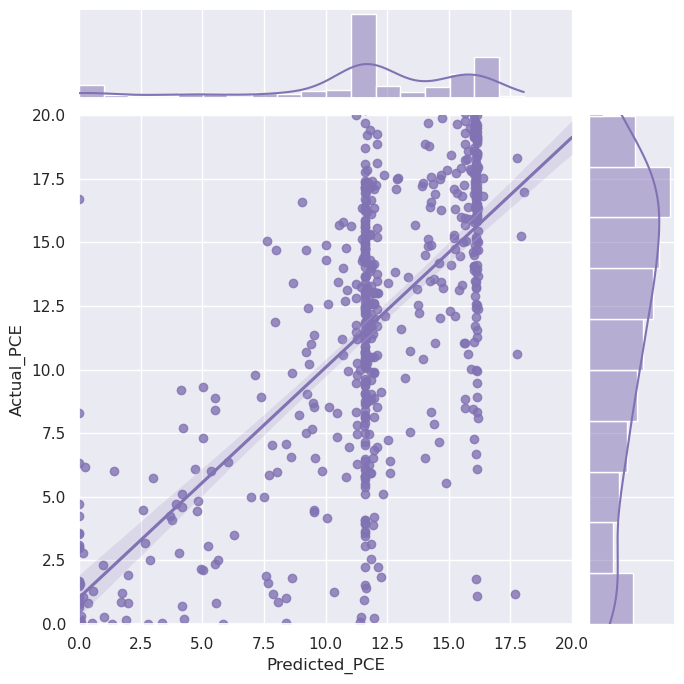

In [221]:
import seaborn as sns
sns.set_theme(style="darkgrid")

pred_flat = [item.item() for sublist in all_predictions for item in sublist]
true_flat = [item.item() for sublist in all_labels for item in sublist]

eval_data = pd.DataFrame({
    'Predicted_PCE': pred_flat,
    'Actual_PCE': true_flat
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 20),
                  color="m", height=7)